In [28]:
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
import joblib

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from src.Bayesian_state import *
from src.Bayesian_state.problems.config import config_fgt
from src.Bayesian_state.problems import *
# from src.Bayesian_state.utils.optimizer import Optimizer, ConstantDict
# from src.Bayesian_state.utils.model_evaluation import ModelEval

In [30]:
processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')

subject_id = 17
subject_data = learning_data[learning_data["iSub"] == subject_id]
condition = subject_data["condition"].iloc[0]
s_data = (
    subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
    subject_data["choice"].values,
    subject_data["feedback"].values
)
print(condition)

2


In [31]:
subject_data.keys()


Index(['iSub', 'version', 'condition', 'structure1', 'structure2', 'iSession',
       'iBlock', 'iTrial', 'neck_length', 'head_length', 'leg_length',
       'tail_length', 'neck_angle', 'head_angle', 'leg_angle', 'tail_angle',
       'feature1', 'feature2', 'feature3', 'feature4', 'category', 'choice',
       'feedback', 'ambigous', 'choRT', 'neck_oral', 'head_oral', 'leg_oral',
       'tail_oral', 'text', 'feature1_oral', 'feature2_oral', 'feature3_oral',
       'feature4_oral', 'neck_use', 'head_use', 'leg_use', 'tail_use',
       'feature1_use', 'feature2_use', 'feature3_use', 'feature4_use'],
      dtype='object')

In [32]:
from src.Bayesian_state.problems import StandardModel, StateModel
from src.Bayesian_state.utils.load_config import MODEL_STRUCT

# 打印字典并排版
import pprint

choice = 'pmh_model'
model = StateModel(MODEL_STRUCT[choice],condition=condition)
pprint.pprint(MODEL_STRUCT[choice])

INFO:cat-learning:  - Module 'perception_mod' registered as 'self.perception_mod'.
INFO:cat-learning:  - Module 'hypo_transitions_mod' registered as 'self.hypo_transitions_mod'.
INFO:cat-learning:  - Module 'likelihood_mod' registered as 'self.likelihood_mod'.
d:\Research\nips_reviewing\CategoryLearning\StateBased\CategoryLearning\src\Bayesian_state\problems\modules\memory.py:172: RuntimeWarning: divide by zero encountered in log
  return np.log(clipped)
INFO:cat-learning:  - Module 'memory_mod' registered as 'self.memory_mod'.


{'perception_mod': {'class': 'src.Bayesian_state.problems.modules.perception.PerceptionModule', 'kwargs': {'mean': 0.0, 'std': 0.05}}, 'hypo_transitions_mod': {'class': 'src.Bayesian_state.problems.modules.hypo_transitions.FixedNumHypothesisModule', 'kwargs': {'fixed_hypo_num': 10, 'init_strategy': 'random', 'transition_mode': 'top_posterior', 'throw_num': 1}}, 'likelihood_mod': {'class': 'src.Bayesian_state.problems.modules.likelihood.LikelihoodModule', 'kwargs': {'beta': 5.0}}, 'memory_mod': {'class': 'src.Bayesian_state.problems.modules.memory.DualMemoryModule', 'kwargs': {'w0': 0.8, 'gamma': 0.8}}}
name: perception_mod mod_kwargs: {'mean': 0.0, 'std': 0.05}
name: hypo_transitions_mod mod_kwargs: {'fixed_hypo_num': 10, 'init_strategy': 'random', 'transition_mode': 'top_posterior', 'throw_num': 1}
name: likelihood_mod mod_kwargs: {'beta': 5.0}
name: memory_mod mod_kwargs: {'w0': 0.8, 'gamma': 0.8}
{'agenda': ['perception_mod',
            'hypo_transitions_mod',
            'likeliho

In [33]:
# 按trial重整数据
input_data = []
trial_total_num = subject_data.shape[0]
for i in range(trial_total_num):
    input_data.append([s_data[0][i],s_data[1][i], s_data[2][i]])


print(input_data[:5])  # 打印前5个trial

[[array([0.50255826, 0.98811017, 0.77159335, 0.99698384]), np.int64(2), np.float64(0.0)], [array([0.96243671, 0.34515871, 0.80833906, 0.79065973]), np.int64(2), np.float64(0.0)], [array([0.69359518, 0.98701254, 0.21934116, 0.07771833]), np.int64(2), np.float64(0.0)], [array([0.92930833, 0.06842905, 0.72994654, 0.3930689 ]), np.int64(4), np.float64(1.0)], [array([0.20904841, 0.58905002, 0.69392378, 0.48564343]), np.int64(2), np.float64(1.0)]]


In [34]:
results_state = model.fit_step_by_step(input_data, use_boundary=False)

[7]
[49]
[27]
[23]
[20]
[15]
[16]
[86]
[97]
[77]
[111]
[65]
[80]
[81]
[112]
[57]
[32]
[35]
[9]
[72]
[44]
[111]
[100]
[79]
[3]
[37]
[0]
[56]
[2]
[44]
[41]
[29]
[11]
[61]
[6]
[7]
[95]
[43]
[53]
[64]
[21]
[102]
[46]
[61]
[59]
[113]
[20]
[53]
[84]
[36]
[20]
[0]
[102]
[10]
[82]
[79]
[87]
[38]
[101]
[30]
[112]
[5]
[111]
[99]
[59]
[92]
[4]
[111]
[26]
[89]
[81]
[67]
[37]
[15]
[97]
[3]
[46]
[73]
[0]
[38]
[98]
[50]
[99]
[32]
[58]
[88]
[34]
[16]
[16]
[5]
[10]
[11]
[51]
[69]
[93]
[115]
[55]
[56]
[29]
[105]
[60]
[84]
[0]
[79]
[83]
[33]
[3]
[85]
[38]
[35]
[26]
[83]
[80]
[32]
[72]
[8]
[45]
[10]
[64]
[73]
[102]
[86]
[70]
[115]
[73]
[31]
[87]
[84]
[6]
[92]
[111]
[15]
[4]
[95]
[13]
[84]
[54]
[69]
[35]
[83]
[65]
[46]
[112]
[47]
[80]
[26]
[59]
[89]
[25]
[41]
[52]
[58]
[112]
[27]
[107]
[1]
[36]
[41]
[32]
[63]
[71]
[45]
[13]
[106]
[48]
[76]
[20]
[65]
[32]
[8]
[60]
[2]
[111]
[58]
[70]
[95]
[80]
[79]
[70]
[2]
[86]
[110]
[3]
[67]
[98]
[31]
[0]
[57]
[69]
[39]
[38]
[78]
[110]
[16]
[112]
[77]
[44]
[55]
[23]
[114]

In [35]:
np.asarray(results_state).argmax(axis=1)

array([ 16,  23, 111,   9,   9,   9,   9,   9,   9,   9,   9,   7,   7,
         7,   7,   7,   0,   0, 113, 113, 113, 102, 102, 102, 102, 102,
       102, 102,   6,   6, 113,  67,  67,  67,  67,  67,   0,   0,   0,
        69,  69,  69,  69,  69, 106, 106, 106, 106, 106,  69, 106, 106,
       106,  69,  69,  69,  69,  69,  69,  69,  69,  69,  69,  69,  69,
        69,  69,  69,  38,  38,  98,  98,  98,  98,  98, 106, 106, 106,
       106, 106, 106, 106,  69,  69,  69,  69,  69,  69,  69, 106, 106,
       106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106, 106,
       106, 106, 106, 106, 106, 106, 106,  66,  66,  66,  66,  66,  95,
        95,  95,  66,  95, 106, 106,  66,   6,  66,  66,  66,  66,  66,
        66,  47,  47,  47,  47,  47,  47,  47,  94,  94,  94,  94,  94,
        94,  13,  13,  13,  66,  66,  66,  66,  66,  66,  66,  66,  66,
        66,  66,  66,  66,  66,  94,  66,  65,  65,  94,  94,  42,  94,
        94,  94,  94,  94,  42,  42,  42,  42,  42,  42,  42,  4

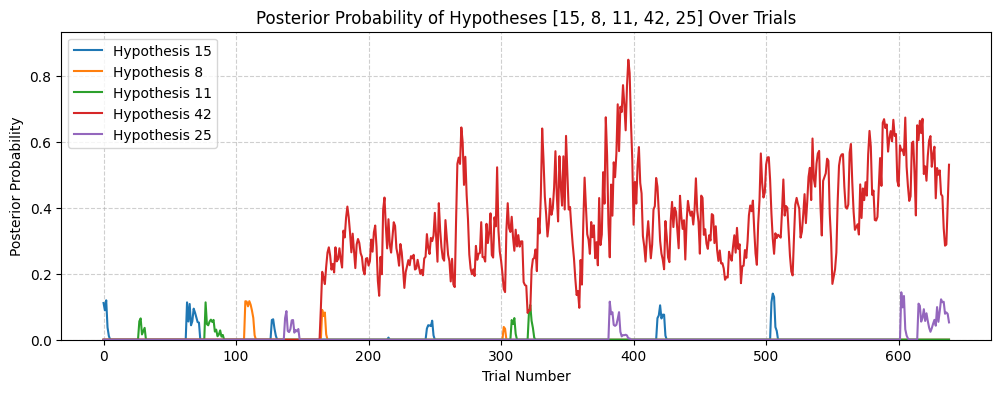

In [36]:
# 画图

import matplotlib.pyplot as plt

def plot_hypo_posterior(posterior_log: list, hypo_indices: list, title: str = None):
    
    plt.figure(figsize=(12, 4))
    
    max_post_overall = 0
    
    # 遍历所有需要绘制的 hypothesis index
    for hypo_index in hypo_indices:
        hypo_posterior_over_time = [posterior[hypo_index] for posterior in posterior_log]
        
        # 找到所有曲线中的最大值，以统一y轴
        max_post = max(hypo_posterior_over_time)
        if max_post > max_post_overall:
            max_post_overall = max_post

        trials = np.arange(len(hypo_posterior_over_time))
        plt.plot(trials, hypo_posterior_over_time, linestyle='-', label=f'Hypothesis {hypo_index}')
    
    if title is None:
        title = f'Posterior Probability of Hypotheses {hypo_indices} Over Trials'
    plt.title(title)
    plt.xlabel('Trial Number')
    plt.ylabel('Posterior Probability')
    plt.ylim(0, max_post_overall * 1.1)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()


hypo_indices = [15, 8, 11, 42, 25]
plot_hypo_posterior(results_state, hypo_indices=hypo_indices)